In [1]:
from colorama import Fore, Style
from datetime import timedelta
from feature_engine.encoding import OneHotEncoder
from folium import plugins
from folium.plugins import HeatMap
from itertools import product as cartessian_product
from matplotlib.ticker import LinearLocator
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
from time import time

import branca
import folium
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cmap
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import lightgbm as lgbm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import warnings
from IPython.display import clear_output

def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))

palette = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
palette_rgb = [hex_to_rgb(x) for x in palette]
cmap = mpl_colors.ListedColormap(palette_rgb)
colors = cmap.colors
bg_color= '#fdfcf6'

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize': 'Large',
    'figure.facecolor': bg_color,
    'axes.facecolor': bg_color
}

sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params
)

warnings.simplefilter("ignore", UserWarning)

In [2]:
train_df = pd.read_csv(r"D:\source\repos\Kaggle_Tabular_Playground_Series-ML\Jan-2023\data\train.csv", index_col=0)
test_df = pd.read_csv(r"D:\source\repos\Kaggle_Tabular_Playground_Series-ML\Jan-2023\data\test.csv", index_col=0)
features = train_df.columns[:-1]

# load original dataset
original_df, original_y = fetch_california_housing(return_X_y=True)
original_df = pd.DataFrame(original_df, columns=features)
original_df['MedHouseVal'] = original_y

In [3]:
cv = KFold(shuffle=True, random_state=2023)
train_df_ = train_df[features]
target = train_df['MedHouseVal']
oof_preds = pd.Series(0, index=train_df.index)
start = time()
tr_losses = []
vl_losses = []
models = []

for fold, (tr_ix, vl_ix) in enumerate(cv.split(train_df, target)):
    X_tr, y_tr = train_df_.iloc[tr_ix], target.iloc[tr_ix]
    X_vl, y_vl = train_df_.iloc[vl_ix], target.iloc[vl_ix]
    
    model = LinearRegression()
    start_fold = time()
    print('_'*50)
    print(f'Fold {fold} | {timedelta(seconds=int(time()-start))}')
    
    model.fit(X_tr, y_tr)
    
    oof_preds.iloc[vl_ix] = model.predict(X_vl)
    tr_losses.append(np.sqrt(mse(y_tr, model.predict(X_tr))))
    vl_losses.append(np.sqrt(mse(y_vl, model.predict(X_vl))))
    models.append(model)

    print(f'Val RMSE: {Fore.BLUE}{vl_losses[-1]}{Style.RESET_ALL}')

print()
print(f'Mean Val RMSE: {Fore.GREEN}{np.mean(vl_losses)}{Style.RESET_ALL}')
print(f'OOF RMSE:      {Fore.GREEN}{np.sqrt(mse(target, oof_preds))}{Style.RESET_ALL}')

__________________________________________________
Fold 0 | 0:00:00
Val RMSE: 0.7484206944595936
__________________________________________________
Fold 1 | 0:00:00
Val RMSE: 0.7139996724392862
__________________________________________________
Fold 2 | 0:00:00
Val RMSE: 0.7183920863729507
__________________________________________________
Fold 3 | 0:00:00
Val RMSE: 1.6608775488196492
__________________________________________________
Fold 4 | 0:00:00
Val RMSE: 0.7402600882549449

Mean Val RMSE: 0.9163900180692849
OOF RMSE:      0.9891810810237041


In [4]:
cv = KFold(shuffle=True, random_state=2023)
train_df_ = train_df[features]
target = train_df['MedHouseVal']
oof_preds = pd.Series(0, index=train_df.index)
start = time()
tr_losses = []
vl_losses = []
models = []

for fold, (tr_ix, vl_ix) in enumerate(cv.split(train_df, target)):
    X_tr, y_tr = train_df_.iloc[tr_ix], target.iloc[tr_ix]
    X_vl, y_vl = train_df_.iloc[vl_ix], target.iloc[vl_ix]
    
    X_tr = pd.concat([X_tr, original_df[features]], axis=0)
    y_tr = pd.concat([y_tr, original_df['MedHouseVal']])
    
    model = LinearRegression()
    start_fold = time()
    print('_'*50)
    print(f'Fold {fold} | {timedelta(seconds=int(time()-start))}')
    
    model.fit(X_tr, y_tr)
    
    oof_preds.iloc[vl_ix] = model.predict(X_vl)
    tr_losses.append(np.sqrt(mse(y_tr, model.predict(X_tr))))
    vl_losses.append(np.sqrt(mse(y_vl, model.predict(X_vl))))
    models.append(model)

    print(f'Val RMSE: {Fore.BLUE}{vl_losses[-1]}{Style.RESET_ALL}')

print()
print(f'Mean Val RMSE: {Fore.GREEN}{np.mean(vl_losses)}{Style.RESET_ALL}')
print(f'OOF RMSE:      {Fore.GREEN}{np.sqrt(mse(target, oof_preds))}{Style.RESET_ALL}')

__________________________________________________
Fold 0 | 0:00:00
Val RMSE: 0.7505449401750277
__________________________________________________
Fold 1 | 0:00:00
Val RMSE: 0.717001052128529
__________________________________________________
Fold 2 | 0:00:00
Val RMSE: 0.7202438485527848
__________________________________________________
Fold 3 | 0:00:00
Val RMSE: 0.7221958580191354
__________________________________________________
Fold 4 | 0:00:00
Val RMSE: 0.7431167312038935

Mean Val RMSE: 0.730620486015874
OOF RMSE:      0.7307461967522509


In [5]:
linespace_start = 0
linespace_end = 1
linespace_ittr = 100
delta = linespace_end - linespace_start
ittr = delta / linespace_ittr
for i, weight in enumerate([linespace_start + ittr*interval for interval in range(linespace_ittr)]):
    print(f"i:{i}, w:{weight}")

i:0, w:0.0
i:1, w:0.01
i:2, w:0.02
i:3, w:0.03
i:4, w:0.04
i:5, w:0.05
i:6, w:0.06
i:7, w:0.07
i:8, w:0.08
i:9, w:0.09
i:10, w:0.1
i:11, w:0.11
i:12, w:0.12
i:13, w:0.13
i:14, w:0.14
i:15, w:0.15
i:16, w:0.16
i:17, w:0.17
i:18, w:0.18
i:19, w:0.19
i:20, w:0.2
i:21, w:0.21
i:22, w:0.22
i:23, w:0.23
i:24, w:0.24
i:25, w:0.25
i:26, w:0.26
i:27, w:0.27
i:28, w:0.28
i:29, w:0.29
i:30, w:0.3
i:31, w:0.31
i:32, w:0.32
i:33, w:0.33
i:34, w:0.34
i:35, w:0.35000000000000003
i:36, w:0.36
i:37, w:0.37
i:38, w:0.38
i:39, w:0.39
i:40, w:0.4
i:41, w:0.41000000000000003
i:42, w:0.42
i:43, w:0.43
i:44, w:0.44
i:45, w:0.45
i:46, w:0.46
i:47, w:0.47000000000000003
i:48, w:0.48
i:49, w:0.49
i:50, w:0.5
i:51, w:0.51
i:52, w:0.52
i:53, w:0.53
i:54, w:0.54
i:55, w:0.55
i:56, w:0.56
i:57, w:0.5700000000000001
i:58, w:0.58
i:59, w:0.59
i:60, w:0.6
i:61, w:0.61
i:62, w:0.62
i:63, w:0.63
i:64, w:0.64
i:65, w:0.65
i:66, w:0.66
i:67, w:0.67
i:68, w:0.68
i:69, w:0.6900000000000001
i:70, w:0.7000000000000001
i:71, w

In [6]:
linespace_start = 0
linespace_end = 1
linespace_ittr = 100
for i, weight in enumerate([linespace_start + linespace_end*interval for interval in range(linespace_ittr)]):
    print(f"i:{i}, w:{weight}")

i:0, w:0
i:1, w:1
i:2, w:2
i:3, w:3
i:4, w:4
i:5, w:5
i:6, w:6
i:7, w:7
i:8, w:8
i:9, w:9
i:10, w:10
i:11, w:11
i:12, w:12
i:13, w:13
i:14, w:14
i:15, w:15
i:16, w:16
i:17, w:17
i:18, w:18
i:19, w:19
i:20, w:20
i:21, w:21
i:22, w:22
i:23, w:23
i:24, w:24
i:25, w:25
i:26, w:26
i:27, w:27
i:28, w:28
i:29, w:29
i:30, w:30
i:31, w:31
i:32, w:32
i:33, w:33
i:34, w:34
i:35, w:35
i:36, w:36
i:37, w:37
i:38, w:38
i:39, w:39
i:40, w:40
i:41, w:41
i:42, w:42
i:43, w:43
i:44, w:44
i:45, w:45
i:46, w:46
i:47, w:47
i:48, w:48
i:49, w:49
i:50, w:50
i:51, w:51
i:52, w:52
i:53, w:53
i:54, w:54
i:55, w:55
i:56, w:56
i:57, w:57
i:58, w:58
i:59, w:59
i:60, w:60
i:61, w:61
i:62, w:62
i:63, w:63
i:64, w:64
i:65, w:65
i:66, w:66
i:67, w:67
i:68, w:68
i:69, w:69
i:70, w:70
i:71, w:71
i:72, w:72
i:73, w:73
i:74, w:74
i:75, w:75
i:76, w:76
i:77, w:77
i:78, w:78
i:79, w:79
i:80, w:80
i:81, w:81
i:82, w:82
i:83, w:83
i:84, w:84
i:85, w:85
i:86, w:86
i:87, w:87
i:88, w:88
i:89, w:89
i:90, w:90
i:91, w:91
i:92, w:

In [7]:
(1 / (2 ** 2))

0.25

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99]
#### Weight 0.00000000
Mean Val RMSE: 0.5696756791088664
OOF RMSE:      0.5697230676302415

#### Weight 0.10000000
Mean Val RMSE: 0.567766457782543
OOF RMSE:      0.5678120545465979

#### Weight 0.20000000
Mean Val RMSE: 0.5664374812983755
OOF RMSE:      0.56648677

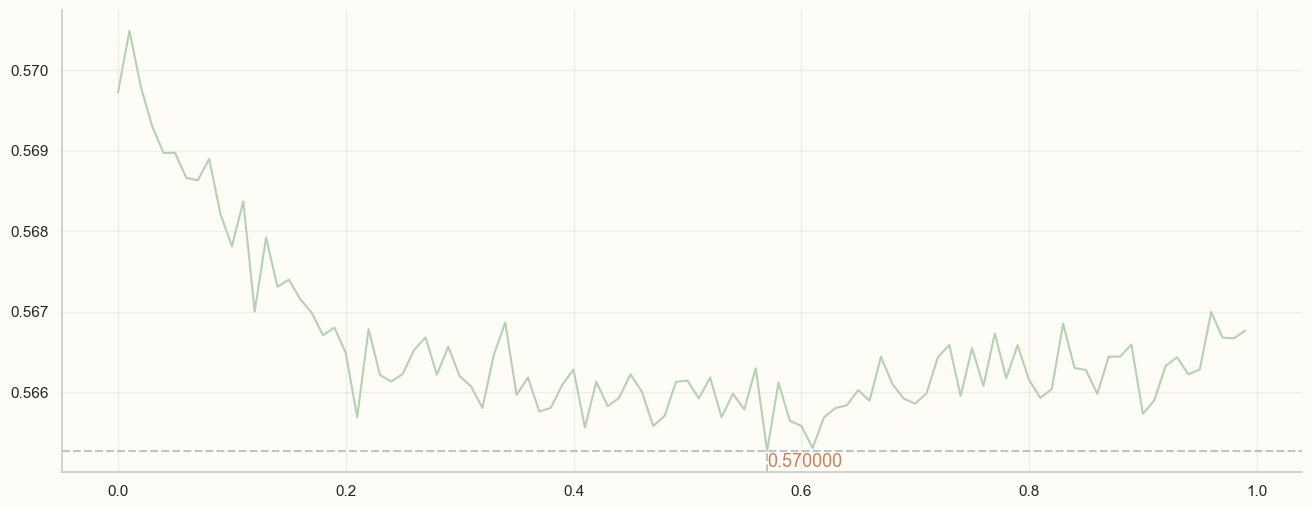

[0.0, 0.0114, 0.0228, 0.0342, 0.0456, 0.057, 0.0684, 0.07980000000000001, 0.0912, 0.1026, 0.114, 0.1254, 0.1368, 0.1482, 0.15960000000000002, 0.171, 0.1824, 0.1938, 0.2052, 0.21660000000000001, 0.228, 0.2394, 0.2508, 0.2622, 0.2736, 0.28500000000000003, 0.2964, 0.3078, 0.31920000000000004, 0.3306, 0.342, 0.3534, 0.3648, 0.37620000000000003, 0.3876, 0.399, 0.4104, 0.4218, 0.43320000000000003, 0.4446, 0.456, 0.46740000000000004, 0.4788, 0.4902, 0.5016, 0.513, 0.5244, 0.5358, 0.5472, 0.5586, 0.5700000000000001, 0.5814, 0.5928, 0.6042000000000001, 0.6156, 0.627, 0.6384000000000001, 0.6498, 0.6612, 0.6726, 0.684, 0.6954, 0.7068, 0.7182000000000001, 0.7296, 0.741, 0.7524000000000001, 0.7638, 0.7752, 0.7866000000000001, 0.798, 0.8094, 0.8208, 0.8322, 0.8436, 0.855, 0.8664000000000001, 0.8778, 0.8892, 0.9006000000000001, 0.912, 0.9234, 0.9348000000000001, 0.9462, 0.9576, 0.9690000000000001, 0.9804, 0.9918, 1.0032, 1.0146, 1.026, 1.0374, 1.0488, 1.0602, 1.0716, 1.083, 1.0944, 1.1058000000000001

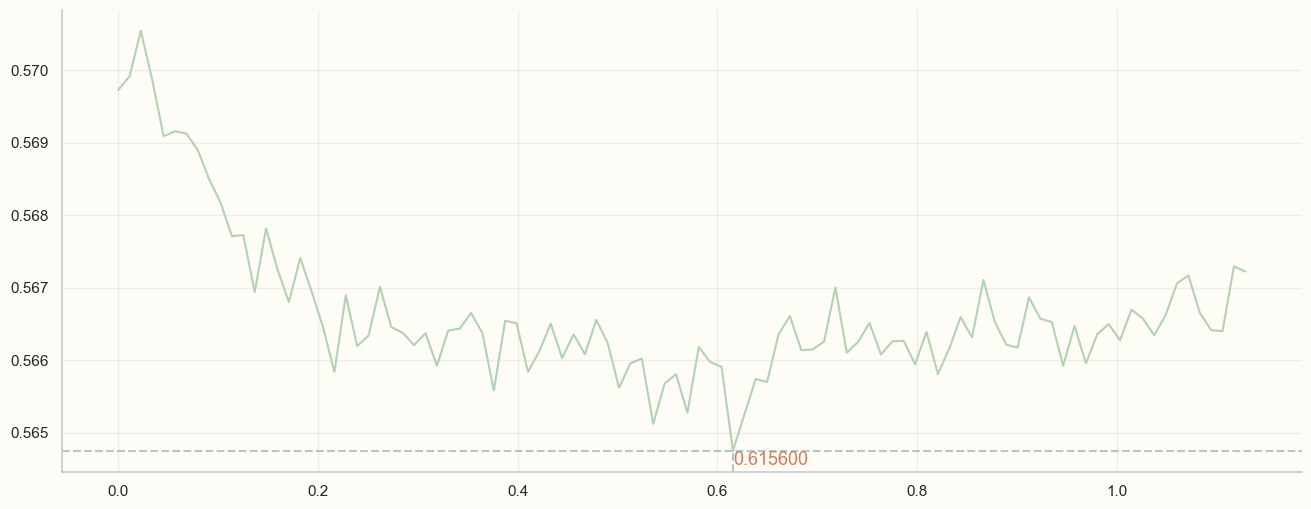

[0.3078, 0.313956, 0.320112, 0.326268, 0.332424, 0.33858, 0.34473600000000004, 0.350892, 0.35704800000000003, 0.363204, 0.36936, 0.375516, 0.381672, 0.387828, 0.393984, 0.40014, 0.406296, 0.412452, 0.418608, 0.42476400000000003, 0.43091999999999997, 0.437076, 0.44323199999999996, 0.449388, 0.455544, 0.4617, 0.467856, 0.474012, 0.480168, 0.486324, 0.49248000000000003, 0.49863599999999997, 0.504792, 0.510948, 0.517104, 0.52326, 0.529416, 0.5355719999999999, 0.541728, 0.547884, 0.55404, 0.5601959999999999, 0.566352, 0.572508, 0.578664, 0.58482, 0.590976, 0.597132, 0.603288, 0.609444, 0.6155999999999999, 0.621756, 0.627912, 0.634068, 0.6402239999999999, 0.64638, 0.652536, 0.6586919999999999, 0.664848, 0.6710039999999999, 0.67716, 0.683316, 0.689472, 0.6956279999999999, 0.701784, 0.70794, 0.714096, 0.7202519999999999, 0.7264079999999999, 0.732564, 0.7387199999999999, 0.744876, 0.7510319999999999, 0.757188, 0.763344, 0.7695, 0.7756559999999999, 0.781812, 0.787968, 0.7941239999999999, 0.80027

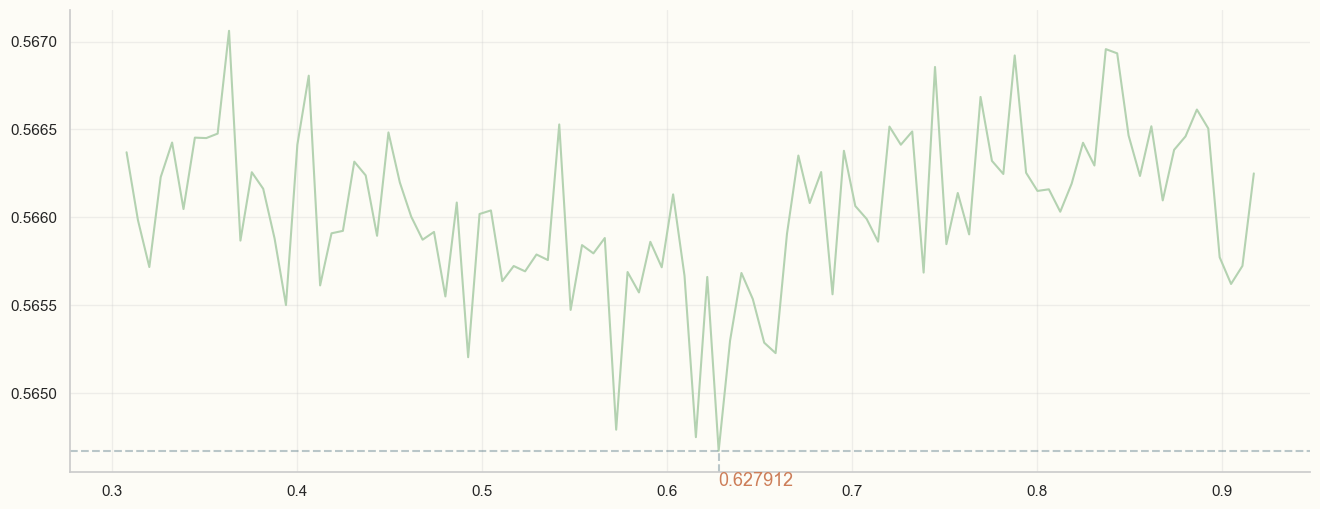

[0.470934, 0.47407356, 0.47721312000000005, 0.48035268000000003, 0.48349224, 0.4866318, 0.48977136000000004, 0.49291092000000003, 0.49605048, 0.49919004, 0.5023296, 0.5054691600000001, 0.50860872, 0.51174828, 0.51488784, 0.5180274, 0.5211669600000001, 0.52430652, 0.52744608, 0.5305856400000001, 0.5337252, 0.53686476, 0.54000432, 0.54314388, 0.5462834400000001, 0.549423, 0.55256256, 0.5557021200000001, 0.55884168, 0.56198124, 0.5651208000000001, 0.56826036, 0.5713999200000001, 0.5745394800000001, 0.57767904, 0.5808186000000001, 0.58395816, 0.58709772, 0.5902372800000001, 0.59337684, 0.5965164000000001, 0.59965596, 0.60279552, 0.6059350800000001, 0.60907464, 0.6122142, 0.6153537600000001, 0.61849332, 0.62163288, 0.6247724400000001, 0.627912, 0.6310515600000001, 0.6341911200000001, 0.63733068, 0.6404702400000001, 0.6436098000000001, 0.64674936, 0.6498889200000001, 0.6530284800000001, 0.6561680400000001, 0.6593076000000001, 0.66244716, 0.6655867200000001, 0.66872628, 0.67186584, 0.67500540

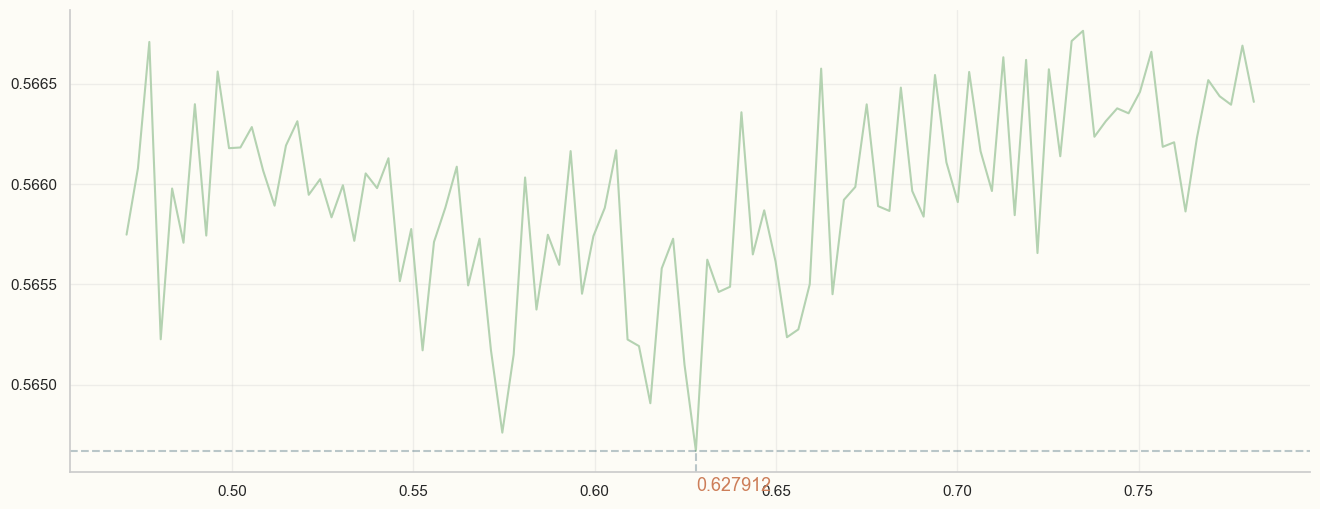

[0.549423, 0.55099278, 0.55256256, 0.55413234, 0.55570212, 0.5572719, 0.55884168, 0.56041146, 0.56198124, 0.56355102, 0.5651208, 0.56669058, 0.56826036, 0.56983014, 0.57139992, 0.5729697, 0.57453948, 0.57610926, 0.57767904, 0.57924882, 0.5808186, 0.58238838, 0.58395816, 0.58552794, 0.58709772, 0.5886675, 0.59023728, 0.59180706, 0.59337684, 0.59494662, 0.5965164000000001, 0.59808618, 0.59965596, 0.6012257400000001, 0.60279552, 0.6043653, 0.6059350800000001, 0.60750486, 0.60907464, 0.6106444200000001, 0.6122142, 0.61378398, 0.6153537600000001, 0.61692354, 0.61849332, 0.6200631, 0.62163288, 0.62320266, 0.62477244, 0.6263422200000001, 0.627912, 0.62948178, 0.6310515600000001, 0.63262134, 0.63419112, 0.6357609000000001, 0.63733068, 0.63890046, 0.6404702400000001, 0.64204002, 0.6436098, 0.64517958, 0.64674936, 0.64831914, 0.64988892, 0.6514587000000001, 0.65302848, 0.65459826, 0.6561680400000001, 0.65773782, 0.6593076, 0.6608773800000001, 0.66244716, 0.66401694, 0.6655867200000001, 0.6671565

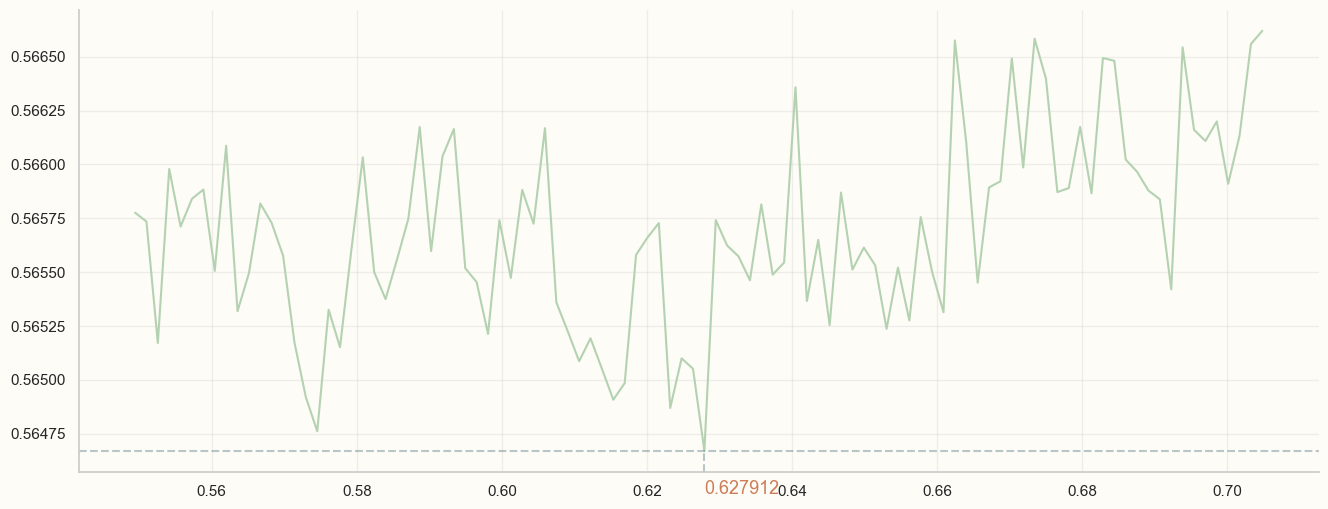

[0.5886675, 0.58945239, 0.59023728, 0.59102217, 0.59180706, 0.59259195, 0.59337684, 0.59416173, 0.59494662, 0.59573151, 0.5965164000000001, 0.59730129, 0.59808618, 0.5988710700000001, 0.59965596, 0.60044085, 0.6012257400000001, 0.60201063, 0.60279552, 0.6035804100000001, 0.6043653, 0.60515019, 0.6059350800000001, 0.60671997, 0.60750486, 0.60828975, 0.60907464, 0.60985953, 0.6106444200000001, 0.61142931, 0.6122142, 0.61299909, 0.61378398, 0.61456887, 0.61535376, 0.61613865, 0.61692354, 0.61770843, 0.61849332, 0.61927821, 0.6200631, 0.62084799, 0.62163288, 0.62241777, 0.62320266, 0.6239875500000001, 0.62477244, 0.62555733, 0.6263422200000001, 0.62712711, 0.627912, 0.6286968900000001, 0.62948178, 0.63026667, 0.6310515600000001, 0.63183645, 0.63262134, 0.6334062300000001, 0.63419112, 0.63497601, 0.6357609000000001, 0.63654579, 0.63733068, 0.6381155700000001, 0.63890046, 0.63968535, 0.6404702400000001, 0.64125513, 0.64204002, 0.6428249100000001, 0.6436098, 0.64439469, 0.64517958, 0.64596447

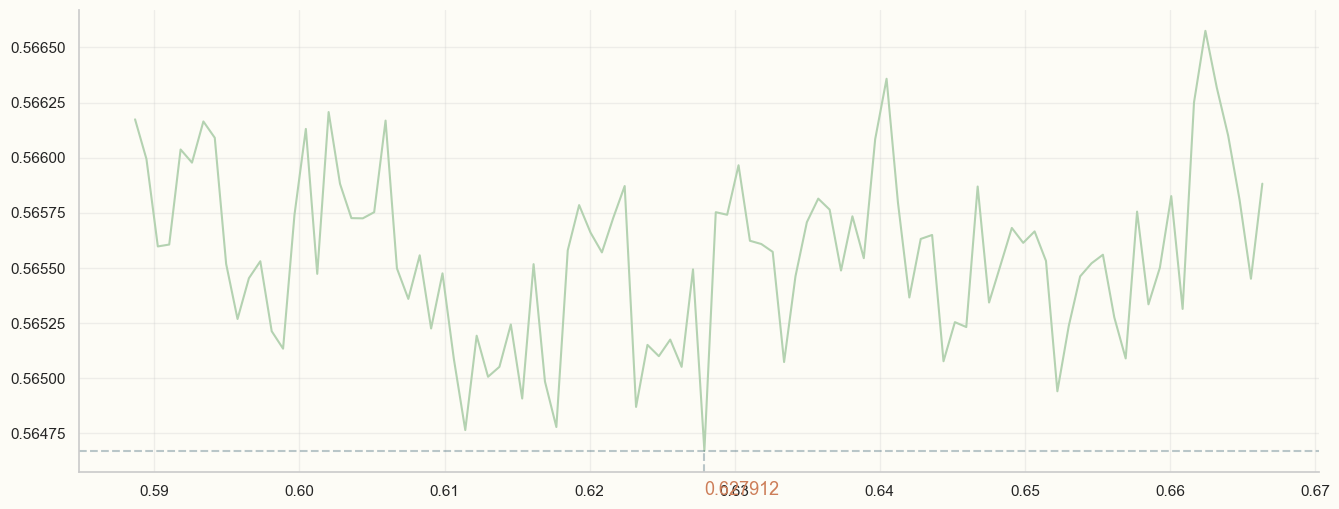

[0.6082897500000001, 0.6086821950000001, 0.6090746400000001, 0.609467085, 0.60985953, 0.6102519750000001, 0.6106444200000001, 0.6110368650000001, 0.6114293100000001, 0.611821755, 0.6122142, 0.6126066450000001, 0.6129990900000001, 0.6133915350000001, 0.61378398, 0.614176425, 0.61456887, 0.6149613150000001, 0.6153537600000001, 0.6157462050000001, 0.61613865, 0.616531095, 0.61692354, 0.6173159850000001, 0.6177084300000001, 0.6181008750000001, 0.61849332, 0.618885765, 0.61927821, 0.6196706550000001, 0.6200631000000001, 0.620455545, 0.62084799, 0.621240435, 0.62163288, 0.6220253250000001, 0.6224177700000001, 0.622810215, 0.62320266, 0.623595105, 0.6239875500000001, 0.6243799950000001, 0.62477244, 0.625164885, 0.62555733, 0.625949775, 0.6263422200000001, 0.6267346650000001, 0.62712711, 0.627519555, 0.627912, 0.628304445, 0.6286968900000001, 0.629089335, 0.62948178, 0.629874225, 0.63026667, 0.630659115, 0.6310515600000001, 0.631444005, 0.63183645, 0.632228895, 0.63262134, 0.633013785, 0.63340

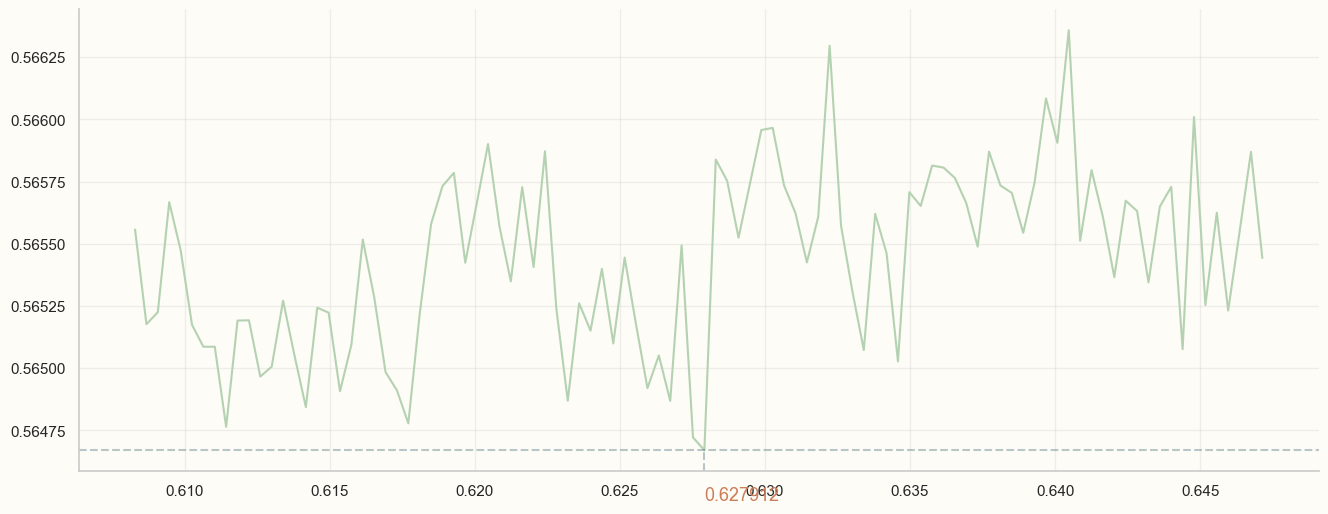

[0.618100875, 0.6182970975, 0.61849332, 0.6186895425, 0.618885765, 0.6190819875, 0.61927821, 0.6194744325, 0.619670655, 0.6198668775, 0.6200631, 0.6202593225, 0.620455545, 0.6206517675, 0.62084799, 0.6210442125, 0.621240435, 0.6214366575, 0.62163288, 0.6218291025, 0.622025325, 0.6222215475, 0.62241777, 0.6226139925, 0.622810215, 0.6230064375, 0.62320266, 0.6233988825, 0.623595105, 0.6237913275, 0.6239875500000001, 0.6241837725, 0.624379995, 0.6245762175, 0.62477244, 0.6249686625, 0.625164885, 0.6253611075000001, 0.62555733, 0.6257535525, 0.625949775, 0.6261459975, 0.6263422200000001, 0.6265384425, 0.626734665, 0.6269308875, 0.62712711, 0.6273233325, 0.627519555, 0.6277157775000001, 0.627912, 0.6281082225, 0.628304445, 0.6285006675, 0.6286968900000001, 0.6288931125, 0.6290893350000001, 0.6292855575, 0.62948178, 0.6296780025000001, 0.629874225, 0.6300704475000001, 0.63026667, 0.6304628925, 0.630659115, 0.6308553375, 0.6310515600000001, 0.6312477825, 0.6314440050000001, 0.6316402275, 0.63

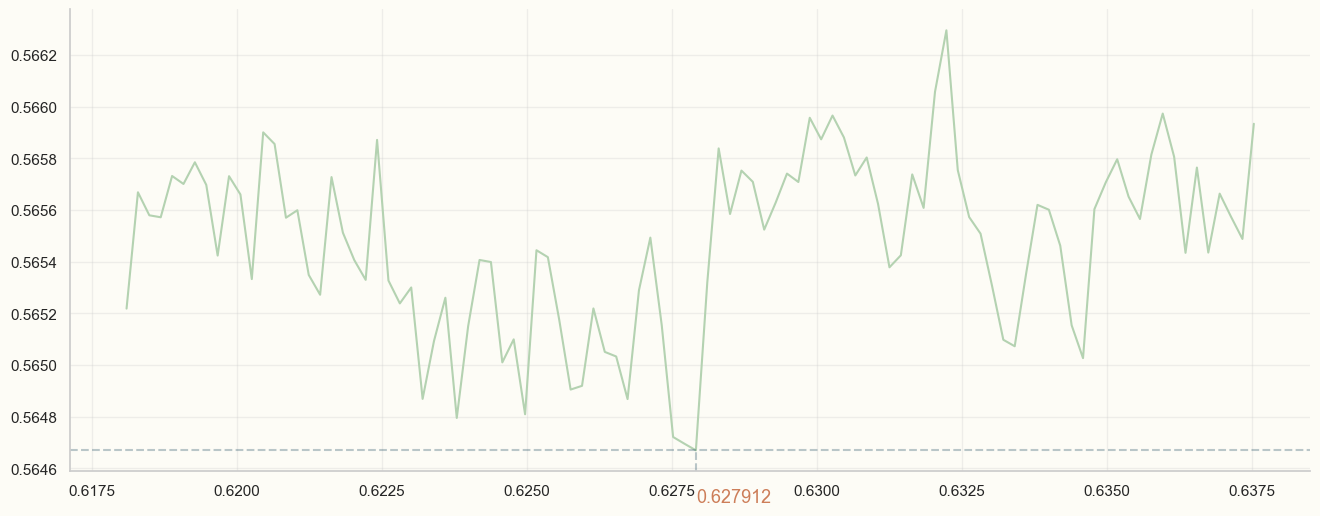

[0.6230064375000001, 0.6231045487500001, 0.62320266, 0.62330077125, 0.6233988825000001, 0.6234969937500001, 0.623595105, 0.6236932162500001, 0.6237913275000001, 0.62388943875, 0.6239875500000001, 0.6240856612500001, 0.6241837725, 0.62428188375, 0.6243799950000001, 0.62447810625, 0.6245762175, 0.6246743287500001, 0.6247724400000001, 0.62487055125, 0.6249686625, 0.6250667737500001, 0.625164885, 0.62526299625, 0.6253611075000001, 0.6254592187500001, 0.62555733, 0.62565544125, 0.6257535525000001, 0.62585166375, 0.625949775, 0.6260478862500001, 0.6261459975, 0.62624410875, 0.6263422200000001, 0.62644033125, 0.6265384425, 0.62663655375, 0.6267346650000001, 0.62683277625, 0.6269308875, 0.6270289987500001, 0.62712711, 0.62722522125, 0.6273233325, 0.6274214437500001, 0.627519555, 0.62761766625, 0.6277157775000001, 0.62781388875, 0.627912, 0.6280101112500001, 0.6281082225, 0.62820633375, 0.628304445, 0.62840255625, 0.6285006675, 0.62859877875, 0.6286968900000001, 0.62879500125, 0.6288931125, 0.6

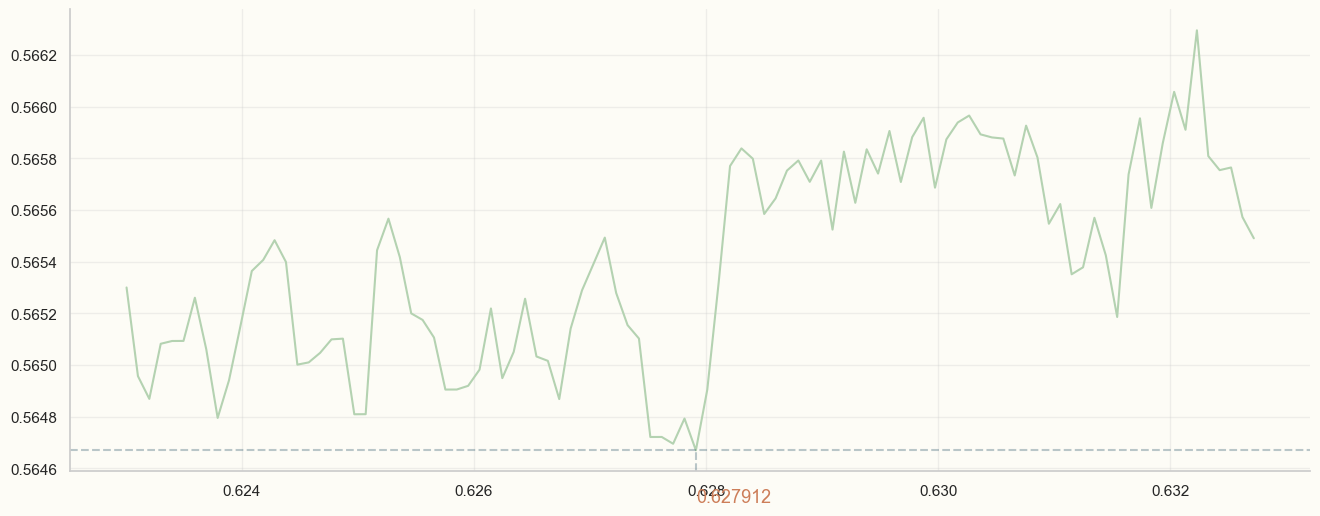

[0.62545921875, 0.625508274375, 0.62555733, 0.625606385625, 0.6256554412499999, 0.625704496875, 0.6257535525, 0.625802608125, 0.62585166375, 0.625900719375, 0.625949775, 0.625998830625, 0.62604788625, 0.626096941875, 0.6261459975, 0.626195053125, 0.62624410875, 0.626293164375, 0.62634222, 0.626391275625, 0.62644033125, 0.626489386875, 0.6265384425, 0.626587498125, 0.62663655375, 0.626685609375, 0.626734665, 0.626783720625, 0.62683277625, 0.626881831875, 0.6269308875, 0.626979943125, 0.6270289987500001, 0.627078054375, 0.62712711, 0.627176165625, 0.62722522125, 0.627274276875, 0.6273233325, 0.6273723881250001, 0.62742144375, 0.627470499375, 0.627519555, 0.627568610625, 0.62761766625, 0.627666721875, 0.6277157775000001, 0.627764833125, 0.62781388875, 0.627862944375, 0.627912, 0.627961055625, 0.6280101112500001, 0.6280591668750001, 0.6281082225, 0.628157278125, 0.62820633375, 0.628255389375, 0.628304445, 0.6283535006250001, 0.6284025562500001, 0.628451611875, 0.6285006675, 0.628549723125,

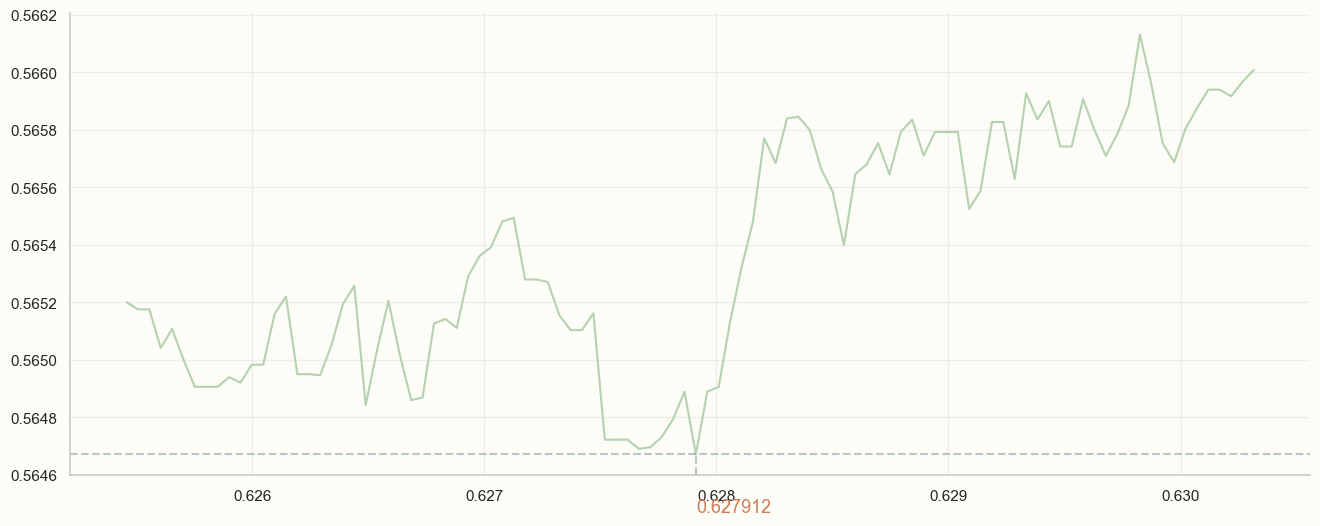

[0.6266856093750001, 0.6267101371875, 0.6267346650000001, 0.6267591928125, 0.6267837206250001, 0.6268082484375, 0.6268327762500001, 0.6268573040625001, 0.626881831875, 0.6269063596875001, 0.6269308875, 0.6269554153125001, 0.626979943125, 0.6270044709375, 0.6270289987500001, 0.6270535265625, 0.6270780543750001, 0.6271025821875, 0.6271271100000001, 0.6271516378125, 0.627176165625, 0.6272006934375001, 0.62722522125, 0.6272497490625001, 0.627274276875, 0.6272988046875001, 0.6273233325, 0.6273478603125, 0.6273723881250001, 0.6273969159375, 0.6274214437500001, 0.6274459715625, 0.627470499375, 0.6274950271875, 0.627519555, 0.6275440828125001, 0.627568610625, 0.6275931384375001, 0.62761766625, 0.6276421940625, 0.627666721875, 0.6276912496875, 0.6277157775000001, 0.6277403053125, 0.627764833125, 0.6277893609375, 0.62781388875, 0.6278384165625001, 0.627862944375, 0.6278874721875001, 0.627912, 0.6279365278125, 0.627961055625, 0.6279855834375, 0.6280101112500001, 0.6280346390625, 0.628059166875000

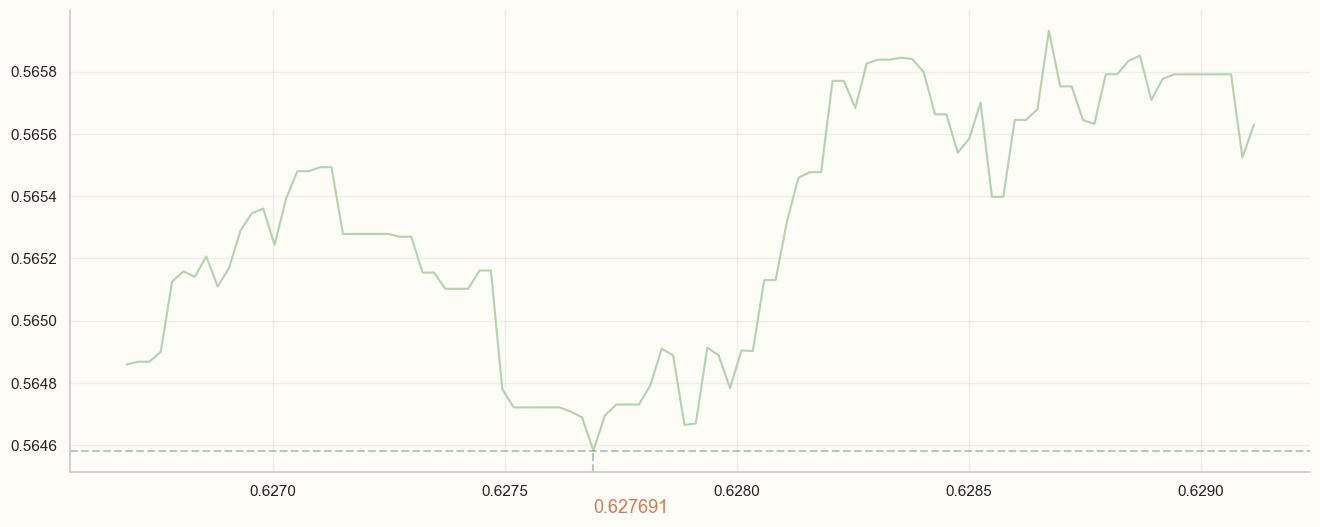

[0.6270782699514771, 0.6270905295461976, 0.627102789140918, 0.6271150487356385, 0.6271273083303589, 0.6271395679250794, 0.6271518275197998, 0.6271640871145203, 0.6271763467092407, 0.6271886063039612, 0.6272008658986816, 0.6272131254934021, 0.6272253850881225, 0.627237644682843, 0.6272499042775636, 0.627262163872284, 0.6272744234670045, 0.6272866830617249, 0.6272989426564454, 0.6273112022511658, 0.6273234618458863, 0.6273357214406067, 0.6273479810353272, 0.6273602406300476, 0.6273725002247681, 0.6273847598194886, 0.627397019414209, 0.6274092790089295, 0.6274215386036499, 0.6274337981983704, 0.6274460577930908, 0.6274583173878113, 0.6274705769825317, 0.6274828365772522, 0.6274950961719726, 0.6275073557666931, 0.6275196153614135, 0.627531874956134, 0.6275441345508546, 0.627556394145575, 0.6275686537402955, 0.6275809133350159, 0.6275931729297364, 0.6276054325244568, 0.6276176921191773, 0.6276299517138977, 0.6276422113086182, 0.6276544709033386, 0.6276667304980591, 0.6276789900927795, 0.627

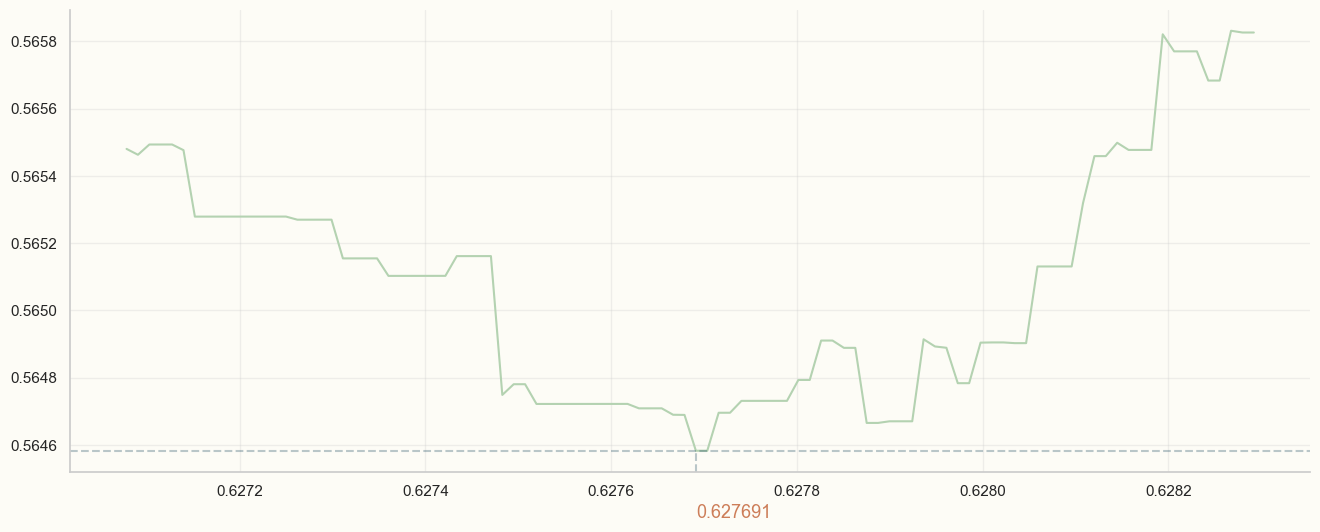

[0.6273847598194885, 0.6273908896168487, 0.627397019414209, 0.6274031492115691, 0.6274092790089294, 0.6274154088062897, 0.6274215386036499, 0.62742766840101, 0.6274337981983703, 0.6274399279957306, 0.6274460577930908, 0.6274521875904511, 0.6274583173878112, 0.6274644471851715, 0.6274705769825317, 0.627476706779892, 0.6274828365772521, 0.6274889663746124, 0.6274950961719726, 0.6275012259693329, 0.6275073557666931, 0.6275134855640533, 0.6275196153614135, 0.6275257451587738, 0.627531874956134, 0.6275380047534942, 0.6275441345508544, 0.6275502643482147, 0.627556394145575, 0.6275625239429352, 0.6275686537402954, 0.6275747835376556, 0.6275809133350159, 0.6275870431323761, 0.6275931729297364, 0.6275993027270965, 0.6276054325244568, 0.627611562321817, 0.6276176921191773, 0.6276238219165374, 0.6276299517138977, 0.6276360815112579, 0.6276422113086182, 0.6276483411059784, 0.6276544709033386, 0.6276606007006988, 0.6276667304980591, 0.6276728602954194, 0.6276789900927795, 0.6276851198901398, 0.6276

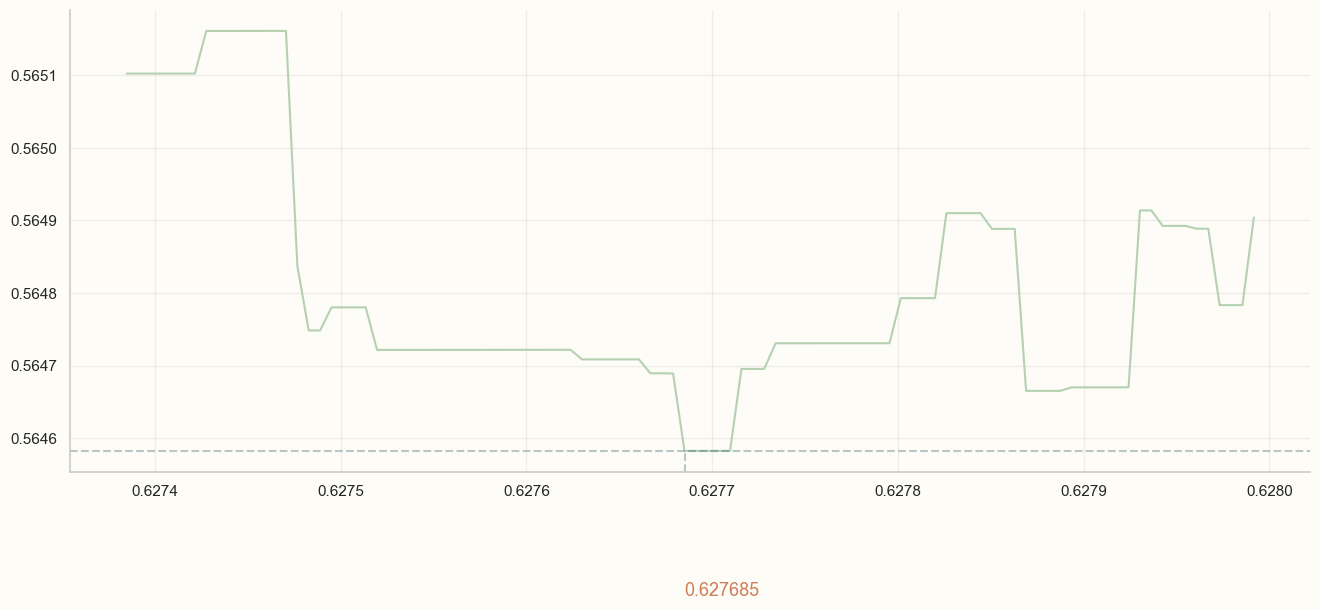

[0.6275318764526666, 0.6275349413214161, 0.6275380061901655, 0.627541071058915, 0.6275441359276644, 0.6275472007964139, 0.6275502656651634, 0.6275533305339128, 0.6275563954026623, 0.6275594602714117, 0.6275625251401612, 0.6275655900089107, 0.6275686548776601, 0.6275717197464097, 0.6275747846151591, 0.6275778494839086, 0.6275809143526581, 0.6275839792214075, 0.627587044090157, 0.6275901089589064, 0.6275931738276559, 0.6275962386964054, 0.6275993035651548, 0.6276023684339043, 0.6276054333026537, 0.6276084981714032, 0.6276115630401526, 0.6276146279089021, 0.6276176927776516, 0.627620757646401, 0.6276238225151505, 0.6276268873838999, 0.6276299522526494, 0.6276330171213989, 0.6276360819901483, 0.6276391468588978, 0.6276422117276472, 0.6276452765963967, 0.6276483414651463, 0.6276514063338957, 0.6276544712026452, 0.6276575360713946, 0.6276606009401441, 0.6276636658088935, 0.627666730677643, 0.6276697955463925, 0.6276728604151419, 0.6276759252838914, 0.6276789901526408, 0.6276820550213903, 0.6

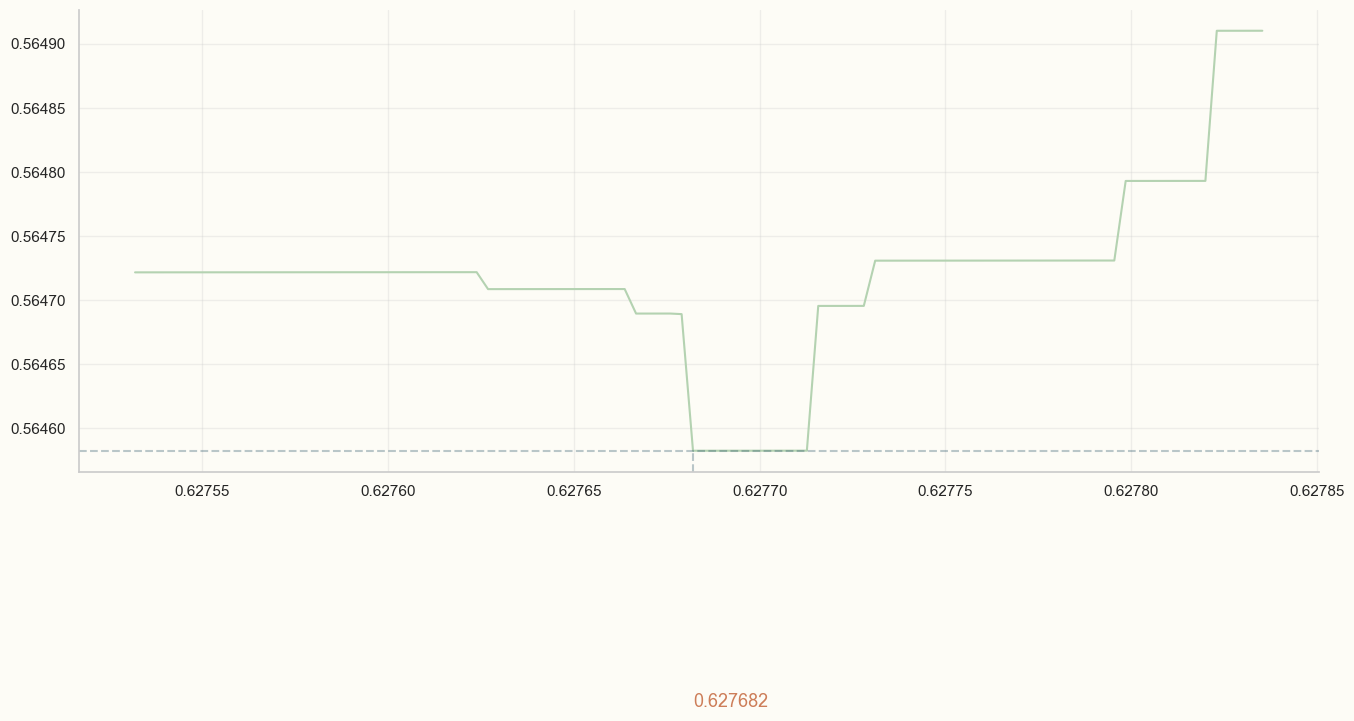

[0.6276054336767832, 0.6276069661036754, 0.6276084985305675, 0.6276100309574597, 0.6276115633843518, 0.6276130958112439, 0.6276146282381361, 0.6276161606650282, 0.6276176930919204, 0.6276192255188126, 0.6276207579457046, 0.6276222903725968, 0.6276238227994889, 0.6276253552263811, 0.6276268876532732, 0.6276284200801654, 0.6276299525070574, 0.6276314849339496, 0.6276330173608418, 0.6276345497877339, 0.6276360822146261, 0.6276376146415182, 0.6276391470684103, 0.6276406794953024, 0.6276422119221946, 0.6276437443490868, 0.6276452767759789, 0.6276468092028711, 0.6276483416297632, 0.6276498740566553, 0.6276514064835474, 0.6276529389104396, 0.6276544713373318, 0.6276560037642239, 0.6276575361911161, 0.6276590686180081, 0.6276606010449003, 0.6276621334717924, 0.6276636658986846, 0.6276651983255768, 0.6276667307524689, 0.627668263179361, 0.6276697956062531, 0.6276713280331453, 0.6276728604600375, 0.6276743928869296, 0.6276759253138218, 0.6276774577407138, 0.627678990167606, 0.6276805225944981, 0

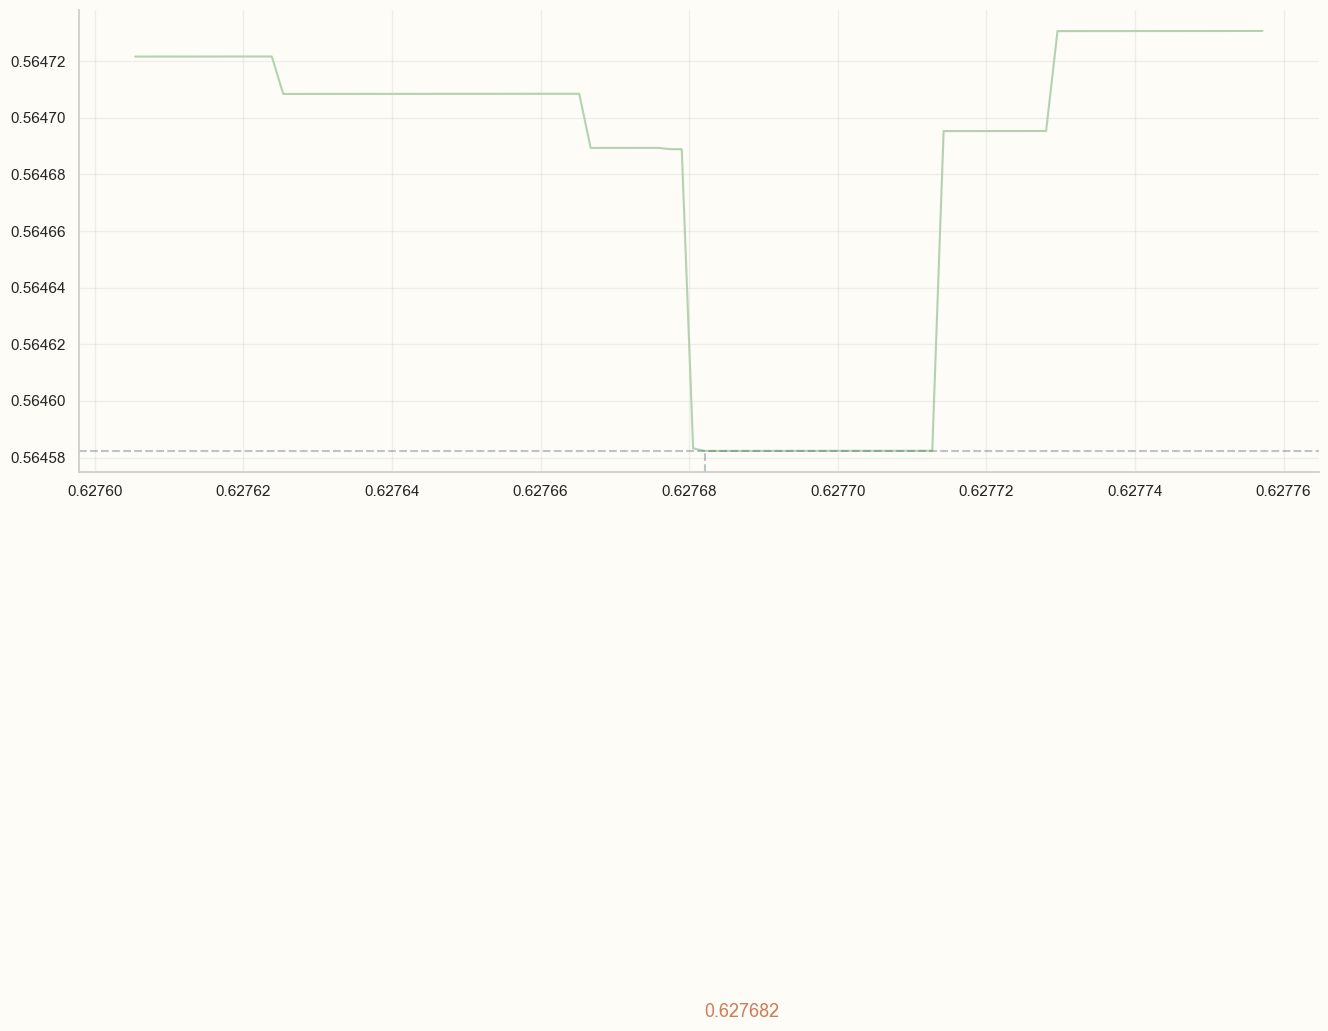

CPU times: total: 16h 41min 1s
Wall time: 34min 13s


In [20]:
%%time
cv = KFold(shuffle=True, random_state=2024, n_splits=5)
train_df_ = train_df[features].copy()
original_df_ = original_df.copy()
total_results = {}
results = {}
models = {}
best_results_histroy = []
best_model_history = {}

total_predis = pd.Series(0, index=test_df.index)


linespace_start = 0
linespace_end = 1
linespace_ittr = 100

depth = 15

for j in range(depth):
    results = {}
    models = {}
    delta = linespace_end - linespace_start
    ittr = delta / linespace_ittr
    linespace = [linespace_start + ittr*interval for interval in range(linespace_ittr)]
    print(linespace)
    for i, weight in enumerate(linespace):
        train_df_['weight'] = 1
        original_df_['weight'] = weight

        target = train_df['MedHouseVal']
        oof_preds = pd.Series(0, index=train_df.index)
        start = time()
        tr_losses = []
        vl_losses = []
        models[weight] = []

        for fold, (tr_ix, vl_ix) in enumerate(cv.split(train_df, target)):
            X_tr, y_tr = train_df_.iloc[tr_ix], target.iloc[tr_ix]
            X_vl, y_vl = train_df_.iloc[vl_ix], target.iloc[vl_ix]

            X_tr = pd.concat([X_tr, original_df_.drop(columns=['MedHouseVal'])], axis=0)
            y_tr = pd.concat([y_tr, original_df_['MedHouseVal']])

            w = X_tr.pop('weight')
            X_vl.pop('weight')

            model = lgbm.LGBMRegressor()
            start_fold = time()

            model.fit(X_tr, y_tr, sample_weight=w)
            oof_preds.iloc[vl_ix] = model.predict(X_vl)
            tr_losses.append(np.sqrt(mse(y_tr, model.predict(X_tr))))
            vl_losses.append(np.sqrt(mse(y_vl, model.predict(X_vl))))
            models[weight].append(model)

        if i % 10 == 0:
            print(f'#### Weight {weight:.8f}')
            print(f'Mean Val RMSE: {Fore.GREEN}{np.mean(vl_losses)}{Style.RESET_ALL}')
            print(f'OOF RMSE:      {Fore.GREEN}{np.sqrt(mse(target, oof_preds))}{Style.RESET_ALL}')
            print()
            
        results[weight] = np.sqrt(mse(target, oof_preds))
        total_results[weight] = np.sqrt(mse(target, oof_preds))

    
    best_weight, min_rmse = min(results, key=results.get), min(results.values())
    best_results_histroy.append(best_weight)
    best_model_history[best_weight] = models
    print(f'Min OOF RMSE: {min_rmse:.8f} at sample_weight = {best_weight:.8f}')
    linespace_start = best_weight - (best_weight * (1 / (2 ** j)))
    linespace_end = best_weight + (best_weight * (1 / (2 ** j)))
    print(f"Linespace Range {linespace_start}-{linespace_end}")
    
    mods = models[best_weight]
    for model in mods:
        total_predis += model.predict(test_df)
    
    fig, ax = plt.subplots()
    best_weight, min_rmse = min(results, key=results.get), min(results.values())
    ax.plot(results.keys(), results.values())
    ax.axhline(min_rmse, linestyle='--', color=colors[2], alpha=0.3)

    y_min, y_max = ax.get_ylim()
    ax.axvline(
        best_weight, ymax=(min_rmse -  y_min)/(y_max - y_min),
        linestyle='--', color=colors[2], alpha=0.3
    )

    ax.text(best_weight, min_rmse-0.0002, f'{best_weight:.6f}', color=colors[3], fontsize=13)
    plt.show()
    
    

In [37]:
total_predis /= 75

In [38]:
total_predis

id
37137    0.682389
37138    1.022920
37139    3.998488
37140    3.471219
37141    2.537018
           ...   
61891    2.571108
61892    1.954970
61893    1.236275
61894    3.551092
61895    3.335206
Length: 24759, dtype: float64

In [40]:
test_df_result = test_df.copy()
test_df_result['MedHouseVal'] = total_predis
test_df_result[['MedHouseVal']].to_csv('sumbission.csv')

In [46]:
light_df = pd.read_csv(r"D:\source\repos\Kaggle_Tabular_Playground_Series-ML\Jan-2023\submission_lightbmg.csv", index_col='id')

In [52]:
test_df_result

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
id,,,,,,,,,
37137,1.7062,35.0,4.966368,1.096539,1318.0,2.844411,39.75,-121.85,0.682389
37138,1.3882,22.0,4.187035,1.098229,2296.0,3.180218,33.95,-118.29,1.022920
37139,7.7197,21.0,7.129436,0.959276,1535.0,2.888889,33.61,-117.81,3.998488
37140,4.6806,49.0,4.769697,1.048485,707.0,1.743590,34.17,-118.34,3.471219
37141,3.1284,25.0,3.765306,1.081633,4716.0,2.003827,34.17,-118.29,2.537018
...,...,...,...,...,...,...,...,...,...
61891,2.2875,34.0,3.914729,1.085271,866.0,2.071429,34.44,-119.75,2.571108
61892,3.0781,33.0,4.771971,1.038674,1628.0,2.326848,34.09,-117.96,1.954970
61893,2.6961,14.0,4.593960,1.170380,3900.0,2.540034,37.51,-120.83,1.236275


In [51]:
light_df

,MedHouseVal
id,
37137,0.653218
37138,1.073135
37139,4.036871
37140,3.349312
37141,2.466922
...,...
61891,2.607282
61892,1.896489
61893,1.216823


In [56]:
test_df_result['MedHouseVal'] = (light_df['MedHouseVal'] + test_df_result['MedHouseVal']) /2
test_df_result[['MedHouseVal']].to_csv('sumbission.csv')

Min OOF RMSE: 0.5646 at sample_weight = 0.628


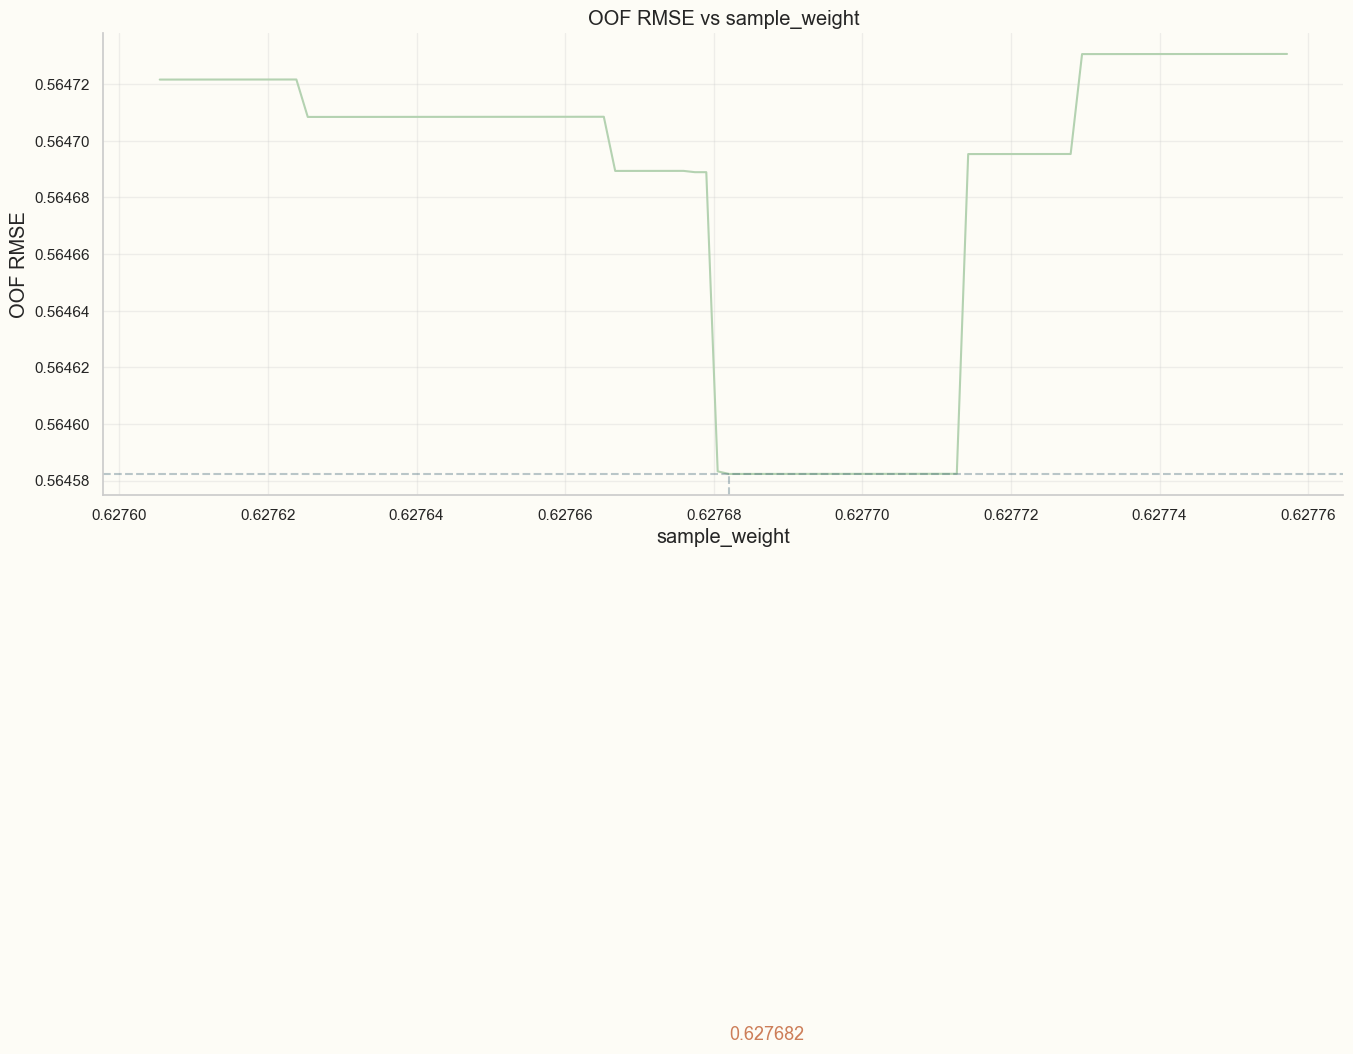

In [23]:
fig, ax = plt.subplots()
best_weight, min_rmse = min(results, key=results.get), min(results.values())
ax.plot(results.keys(), results.values())
ax.axhline(min_rmse, linestyle='--', color=colors[2], alpha=0.3)

y_min, y_max = ax.get_ylim()
ax.axvline(
    best_weight, ymax=(min_rmse -  y_min)/(y_max - y_min),
    linestyle='--', color=colors[2], alpha=0.3
)

ax.text(best_weight, min_rmse-0.0002, f'{best_weight:.6f}', color=colors[3], fontsize=13)

ax.set_title('OOF RMSE vs sample_weight');
ax.set_ylabel('OOF RMSE')
ax.set_xlabel('sample_weight')

print(f'Min OOF RMSE: {min_rmse:.4f} at sample_weight = {best_weight:.3f}')

In [24]:
preds = pd.Series(0, index=test_df.index)
mods = models[best_weight]
for model in mods:
    preds += model.predict(test_df)
preds /= len(mods)

test_df_result = test_df.copy()
test_df_result['MedHouseVal'] = preds
test_df_result[['MedHouseVal']].to_csv('sumbission.csv')

In [11]:
best_results_histroy

[0.5700000000000001,
 0.6156,
 0.627912,
 0.627912,
 0.627912,
 0.627912,
 0.627912,
 0.627912,
 0.627912,
 0.627912,
 0.6276912496875,
 0.6276912496875,
 0.6276851198901398,
 0.6276820550213903,
 0.6276820550213903,
 0.6276812888079443]

In [16]:
best_model_history

{0.5700000000000001: {0.0: [LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor()],
  0.01: [LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor()],
  0.02: [LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor()],
  0.03: [LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor()],
  0.04: [LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor()],
  0.05: [LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor()],
  0.06: [LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor()],
  0.07: [LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor()],
  0.08: [LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor(),
   LGBMRegressor()],
  0.09: [LGBMRegre

In [17]:
best_weight

0.6276812888079443

In [19]:
models

{0.6276621334951755: [LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor()],
 0.6276625166014309: [LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor()],
 0.6276628997076863: [LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor()],
 0.6276632828139417: [LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor()],
 0.6276636659201971: [LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor()],
 0.6276640490264525: [LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor()],
 0.6276644321327077: [LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor()],
 0.6276648152389631: [LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegressor()],
 0.6276651983452185: [LGBMRegressor(),
  LGBMRegressor(),
  LGBMRegresso